/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔥 [Start] L4 Optimized Pipeline with MODEL_IDS

🚀 [Step 1] 누끼 작업 (Model: ZhengPeng7/BiRefNet)...


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


   Step 1 메모리 해제 완료

🚀 [Step 2] 배경 생성 (Model: black-forest-labs/FLUX.1-dev)...


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
  0%|          | 0/25 [00:00<?, ?it/s]/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 25/25 [01:03<00:00,  2.55s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


   Step 2 메모리 해제 완료

🚀 [Step 3-4] 텍스트 효과 (Model: stabilityai/stable-diffusion-xl-base-1.0)...


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


   Step 3-4 메모리 해제 완료

🚀 [Step 5] 레이어 합성 (CPU)...


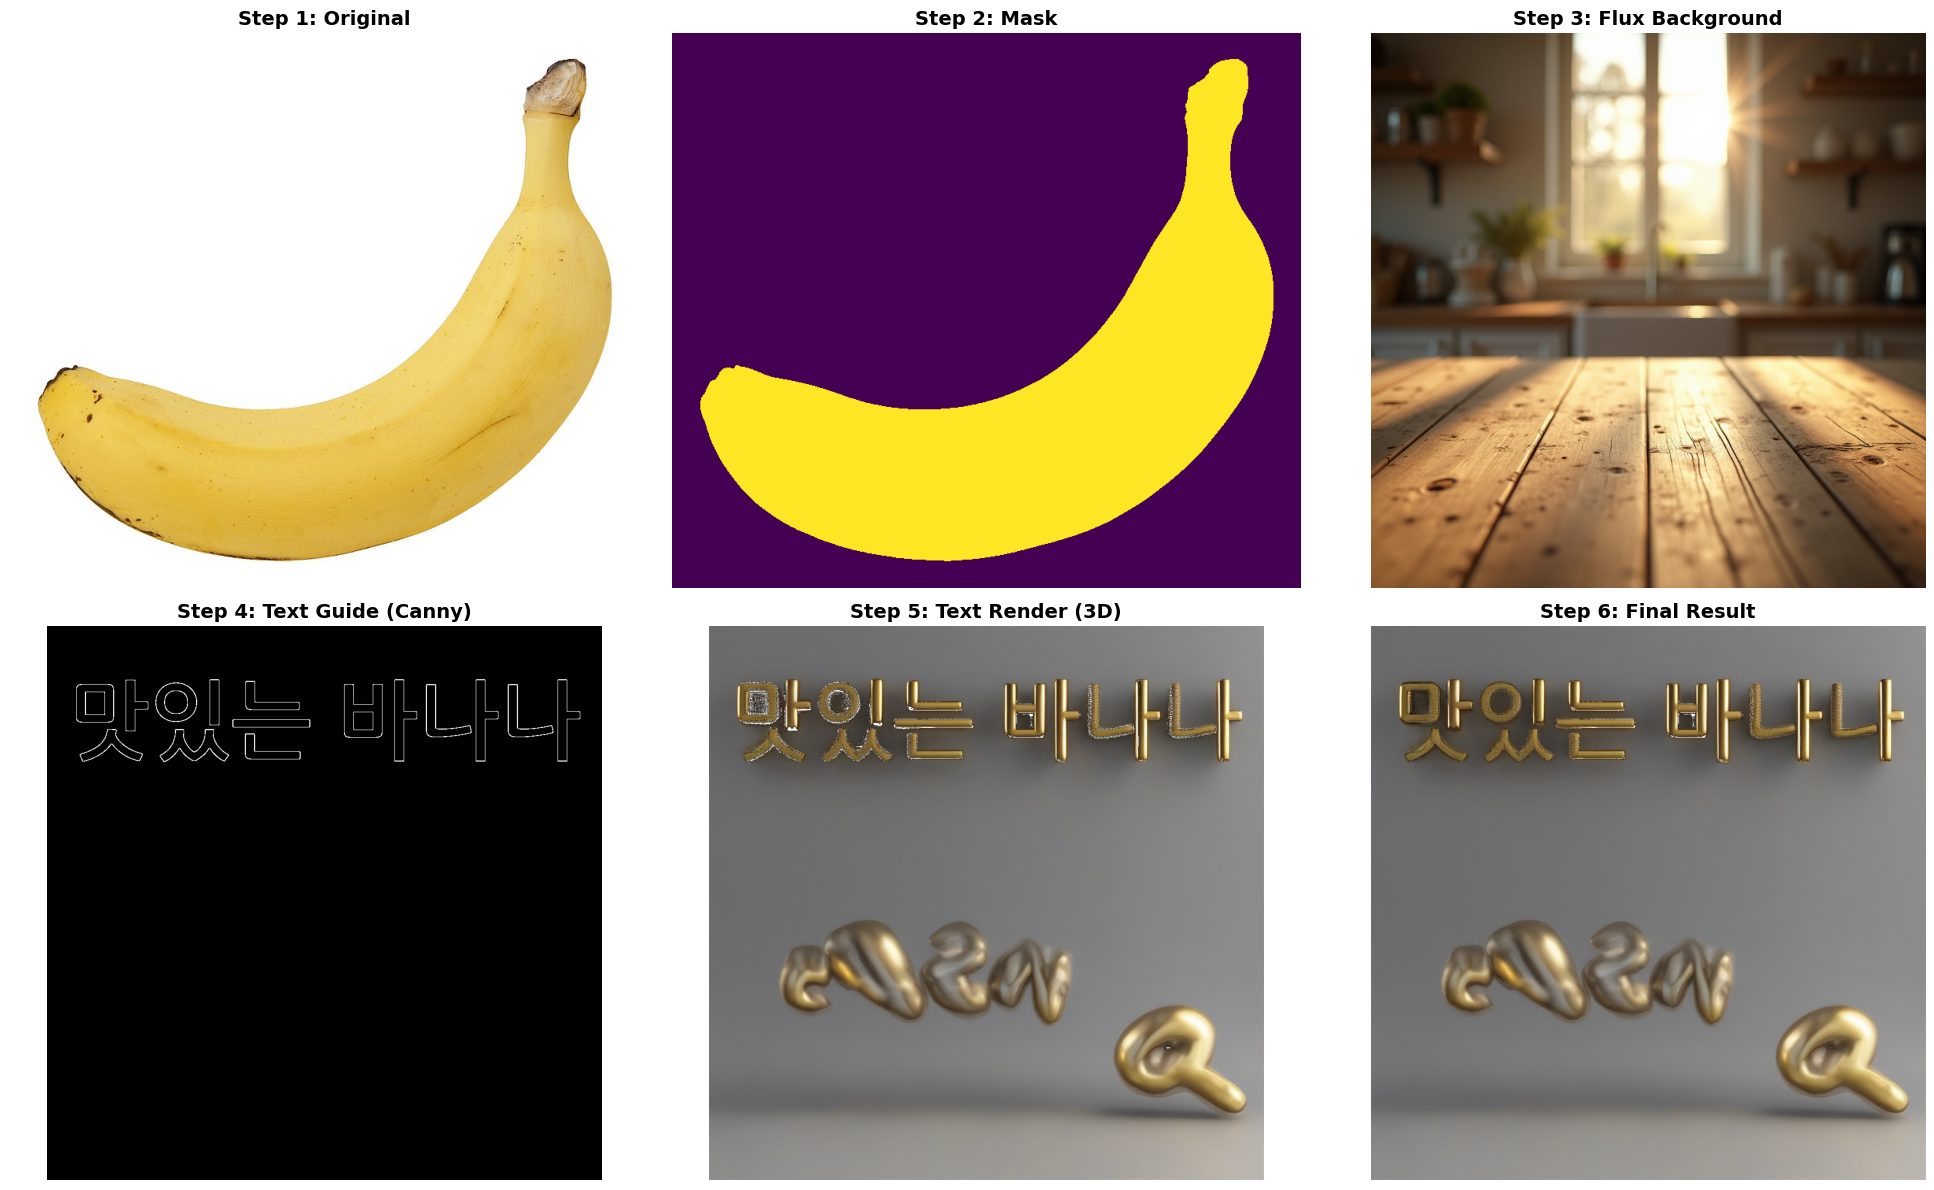

작업 완료


In [1]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import (
    FluxPipeline, 
    FluxTransformer2DModel,
    StableDiffusionXLControlNetPipeline, 
    ControlNetModel, 
    AutoencoderKL
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 통합 설정 (Configuration)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16  # L4 최적화 자료형

# 💡 모델 ID를 중앙에서 관리
MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

def flush():
    """VRAM 메모리 완전 초기화"""
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def pil_canny_edge(image):
    """ControlNet용 엣지 추출 (PIL)"""
    gray = image.convert("L")
    edges = gray.filter(ImageFilter.FIND_EDGES)
    edges = edges.point(lambda x: 255 if x > 30 else 0)
    return edges.convert("RGB")

def visualize_report(images_dict):
    """단계별 시각화 리포트"""
    n = len(images_dict)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(20, 6 * rows))
    for i, (title, img) in enumerate(images_dict.items()):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"Step {i+1}: {title}", fontsize=14, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# [Step 1] 바나나 누끼 (BiRefNet)
# ==========================================
def step1_segmentation(image_path):
    print(f"\n🚀 [Step 1] 누끼 작업 (Model: {MODEL_IDS['SEG']})...")
    flush()
    
    # 1. Load
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    ).to(DEVICE).eval()

    # 2. Run
    img = load_image(image_path).convert("RGB")
    W, H = img.size
    img_resized = img.resize((1024, 1024), Image.LANCZOS)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    
    fg = img.copy()
    fg.putalpha(mask)
    
    # 3. Unload (Strict)
    del birefnet, input_tensor
    flush()
    print("   Step 1 메모리 해제 완료")
    
    return img, fg, mask

# ==========================================
# [Step 2] 배경 생성 (Flux) - L4 최적화
# ==========================================
def step2_background_flux():
    print(f"\n🚀 [Step 2] 배경 생성 (Model: {MODEL_IDS['FLUX']})...")
    flush()
    
    # 1. Load (8-bit Quantization)
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"],
        subfolder="transformer",
        quantization_config=quant_config,
        torch_dtype=TORCH_DTYPE
    )
    
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"],
        transformer=transformer,
        torch_dtype=TORCH_DTYPE
    )
    
    # [핵심] L4(24GB)에서는 Flux Offload 필수
    pipe.enable_model_cpu_offload()
    
    # 2. Run
    prompt = (
        "A close-up view of a rustic wooden table surface. "
        "Soft morning sunlight coming from a window, creating gentle shadows. "
        "Blurred cozy kitchen background, bokeh, photorealistic, 8k, cinematic lighting."
    )
    
    image = pipe(
        prompt, height=1024, width=1024, num_inference_steps=25, guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    # 3. Unload (Strict)
    del pipe, transformer
    flush()
    print("   Step 2 메모리 해제 완료")
    
    return image

# ==========================================
# [Step 3 & 4] 텍스트 이펙트 (SDXL ControlNet)
# ==========================================
def step3_4_text_effects(text="맛있는 바나나"):
    print(f"\n🚀 [Step 3-4] 텍스트 효과 (Model: {MODEL_IDS['SDXL_BASE']})...")
    flush()
    
    # --- 가이드 생성 (CPU) ---
    W, H = 1024, 1024
    font = ImageFont.truetype(download_font(), 160)
    text_guide = Image.new("RGB", (W, H), "black")
    draw = ImageDraw.Draw(text_guide)
    bbox = draw.textbbox((0,0), text, font=font)
    tw = bbox[2] - bbox[0]
    draw.text(((W-tw)//2, 100), text, font=font, fill="white")
    canny_map = pil_canny_edge(text_guide)
    
    # 1. Load
    controlnet = ControlNetModel.from_pretrained(
        MODEL_IDS["SDXL_CNET"], torch_dtype=TORCH_DTYPE, use_safetensors=True
    )
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["SDXL_VAE"], torch_dtype=TORCH_DTYPE)
    
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
        MODEL_IDS["SDXL_BASE"], 
        controlnet=controlnet, 
        vae=vae, 
        torch_dtype=TORCH_DTYPE
    )
    
    # Flux를 내렸으므로 SDXL은 GPU에 직접 올려서 속도 확보
    # (혹시라도 불안하면 pipe.enable_model_cpu_offload()로 변경 가능)
    pipe.to(DEVICE)
    
    # 2. Run
    prompt = (
        "3D render of Gold foil balloon text, inflated, shiny metallic texture, "
        "floating in air, cinematic lighting, sharp details, isolated on black background"
    )
    neg_prompt = "flat, 2d, paper, texture, ugly, white background, low quality"
    
    generated_text_img = pipe(
        prompt, 
        negative_prompt=neg_prompt, 
        image=canny_map, 
        controlnet_conditioning_scale=1.0, 
        num_inference_steps=30
    ).images[0]
    
    # 3. Unload (Strict)
    del pipe, controlnet, vae
    flush()
    print("   Step 3-4 메모리 해제 완료")
    
    # 배경 제거 (Luma Key)
    rgba = generated_text_img.convert("RGBA")
    datas = rgba.getdata()
    new_data = []
    for item in datas:
        if item[0] < 50 and item[1] < 50 and item[2] < 50:
            new_data.append((0, 0, 0, 0))
        else:
            new_data.append(item)
    rgba.putdata(new_data)
    
    return canny_map, rgba

# ==========================================
# [Step 5] 합성 (Composite)
# ==========================================
def step5_composite(bg, fg, text_layer):
    print("\n🚀 [Step 5] 레이어 합성 (CPU)...")
    
    bg_w, bg_h = bg.size
    scale = 0.4
    fg_resized = fg.resize((int(fg.width*scale), int(fg.height*scale)), Image.LANCZOS)
    fg_mask = fg_resized.split()[-1]
    
    x = (bg_w - fg_resized.width) // 2
    y = int(bg_h * 0.55)
    
    shadow = Image.new("RGBA", bg.size, (0,0,0,0))
    shadow.paste((0,0,0,140), (x+20, y+40), mask=fg_mask)
    shadow = shadow.filter(ImageFilter.GaussianBlur(30))
    
    comp = bg.convert("RGBA")
    comp = Image.alpha_composite(comp, shadow)
    
    fg_layer = Image.new("RGBA", bg.size)
    fg_layer.paste(fg_resized, (x, y))
    comp = Image.alpha_composite(comp, fg_layer)
    comp = Image.alpha_composite(comp, text_layer)
    
    return comp.convert("RGB")

# ==========================================
# 🚀 메인 실행
# ==========================================
def main_pipeline(image_path):
    print(f"🔥 [Start] L4 Optimized Pipeline with MODEL_IDS")
    report = {}
    
    # 1. 누끼
    orig, fg, mask = step1_segmentation(image_path)
    report["Original"] = orig
    report["Mask"] = mask
    
    # 2. 배경 (Flux + Offload)
    bg = step2_background_flux()
    report["Flux Background"] = bg
    
    # 3. 텍스트 효과 (SDXL + Direct GPU)
    canny, text_3d = step3_4_text_effects("맛있는 바나나")
    report["Text Guide (Canny)"] = canny
    report["Text Render (3D)"] = text_3d
    
    # 4. 합성
    final = step5_composite(bg, fg, text_3d)
    report["Final Result"] = final
    
    # 시각화
    visualize_report(report)
    final.save("final_result_l4_optimized.png")
    print("작업 완료")

main_pipeline("image.png")